In [36]:
import tensorflow as tf
tf.config.experimental.set_visible_devices(devices=tf.config.experimental.list_physical_devices(device_type='GPU')[0], device_type='GPU')
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import copy

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.__version__)
print(tf.config.list_physical_devices(), tf.test.is_gpu_available(),  tf.test.is_built_with_cuda())

2.4.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] True True


In [37]:
import FrostAPI
import datetime
frost = FrostAPI.FrostApiCaller()

print("Oslo temperature:", frost.get_last_hour()[0]['observations'][0]['value'], "C")

Oslo temperature: 2.1 C


In [39]:
Query = {'elements' : 'air_temperature,max(wind_speed_of_gust PT1H),max(wind_speed PT1H),max_wind_speed(wind_from_direction PT1H)', 'timeresolutions':'PT1H'}
dataset_2days = frost.get_last_hours(48, query=Query)

def frost_to_numpy(data):
    last_hours = []
    for i,e in enumerate(data):
        obs = e['observations']
        air_temp = obs[0]['value']
        wind_speed = obs[2]['value']
        wind_dir = obs[3]['value']
        wind_gust = obs[4]['value']
        hour = (datetime.datetime.now().hour - len(data) + 1) + i
        d = [air_temp, wind_gust, wind_speed, wind_dir, hour]
        last_hours.append(d)
    return np.array(last_hours)

d_input = frost_to_numpy(dataset_2days['data'])

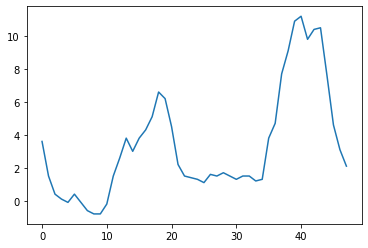

In [40]:
# Temperature last 48 hours
plt.plot(d_input[:,0])

In [6]:
# Load model
model = keras.models.load_model(f"./models/2xBiLSTM-B128_model-28-0.744.model") # Load a model

In [42]:
# Forecast next 12 hours
# Model predict:

# 0.01828154, 0.04310345, 0.08, 0.00277778, 0.04347826
scaled_input = copy.deepcopy(d_input)
scaled_input[:,0] *= 0.01828154
scaled_input[:,1] *= 0.04310345
scaled_input[:,2] *= 0.08
scaled_input[:,3] *= 0.00277778
scaled_input[:,4] *= 0.04347826
unscaled_pred = model.predict(scaled_input.reshape(1, scaled_input.shape[0], scaled_input.shape[1]))

(12, 5)


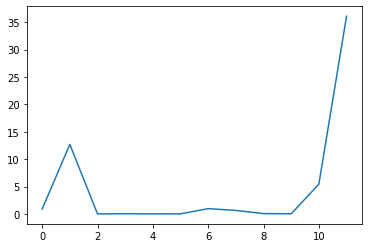

In [72]:
scaled_output = copy.deepcopy(unscaled_pred).reshape(12,5)

scaled_output[:,0] /= 0.01828154
scaled_output[:,1] /= 0.04310345
scaled_output[:,2] /= 0.08
scaled_output[:,3] /= 0.00277778
scaled_output[:,4] /= 0.04347826

scaled_output*=10

print(scaled_output.shape)
temperature = scaled_output[:,0]
plt.plot(scaled_output[:,4])